In [104]:
import pandas as pd
import numpy as np


## Linear Regression
- Stock Price

In [177]:
freq = 'Daily'
stock = 'V'
price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
price = price.sort_values(by='Date').reset_index(drop=True)
predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv',index_col='Date')
NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv').set_index(['Date'])
predictors = predictors.merge(NLP,left_index=True,right_index=True,how='left')
predictors = predictors.loc[predictors.index<='2019-12-31',:]
predictors.fillna(0,inplace=True)
#predictors = predictors.drop(['gdp','adjusted_close'],axis=1)
X = predictors.values[:-1,]
y = price.adjusted_close.shift(-1).values[:len(X)]


In [178]:
from sklearn.linear_model import LassoCV,LassoLarsCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore",category=ConvergenceWarning)

In [179]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [180]:
def mse(y_pred, y_true):
    n = len(y_pred)
    return np.sqrt(np.sum(np.square(y_pred - y_true)))/n

In [181]:
scores = []
for i in range(3,15):
    tscv = TimeSeriesSplit(n_splits=i)
    pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    score = pipe.score(X_train, y_train)
    print(score)
    scores.append(score)
n_split = scores.index(min(scores))+2


0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9912235830440596
0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9935389968426734
0.9926963191439083


21762.003921568168 0.04270183561506744


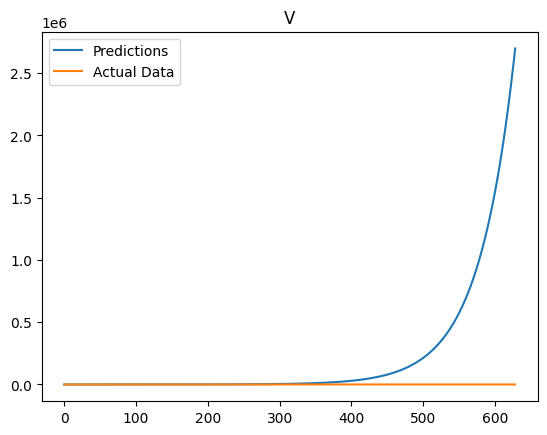

In [182]:
tscv = TimeSeriesSplit(n_splits=6)
pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=2))
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print(mse(y_pred, y_test), mse(y_train, pipe.predict(X_train)))
plt.plot(y_pred,label="Predictions")
plt.plot(y_test,label="Actual Data")
plt.title(stock)
plt.legend()
